# Dataset Creation
Author: Raphael Pereira Rolim e Silva

> Here I try to create the initial dataset for deconvolving HI maps with Neural Networks.

In [36]:
import numpy as np
import healpy as hp
from astropy.io import fits
import matplotlib.pyplot as plt
import sys
import glob
from natsort import natsorted
##############################
from cmcrameri import cm
###############################
sys.path.insert(1, '/media/BINGODATA1/ComponentSeparation/beam_analyzes/scripts')
import handling_data as hdata
import beam_modelling as model

In [37]:
# Get map
path_HI = "/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/HI256/"
filename = 'HI_I_256_980mhz1260mhz_30bins_full_L0001.fits'
HI = hdata.getmap(dirpath_=path_HI, filename_=filename, healpix_readingformat=False, hdu=1)

In [38]:
# Visualize
i1 = np.random.randint(0,30)
hp.mollview(HI[i1], cmap=cm.navia, title=f'HI Map {i1}')

i2 = np.random.randint(0,30)
hp.mollview(HI[i2], cmap=cm.navia, title=f'HI Map {i2}')

## Gaussian smoothed map

Let's start by smoothing our map with a Gaussian beam:

In [11]:
# Adjusting nu
nbands = 30 # 30 bands of frequency
nu_min = 980 # min frequency of observation
nu_max = 1260 # max frequency of observation
nu_step = (nu_max-nu_min)/nbands
nu = np.around(np.arange(nu_min,nu_max,nu_step),decimals=2) # our list of frequencies (nu^n)

In [12]:
# Adjusting ell
nside = hp.get_nside(HI[0])
lmax = 3*nside-1
l = np.arange(lmax) # list of ells from 0 to 3*nside (768)

In [13]:
# FWHM (Delta theta_r)
fwhm  = model.fwhm_modelling(nu=nu[0],type_='smooth', D=40, in_degree=True)

In [14]:
# Adjusting theta
theta = np.arange(0,10,0.01)

In [15]:
# Get gaussian beam
blg = model.bl_function(type_='gaussian', fwhm=fwhm, lmax=lmax, theta_=theta, input_unit='degree')

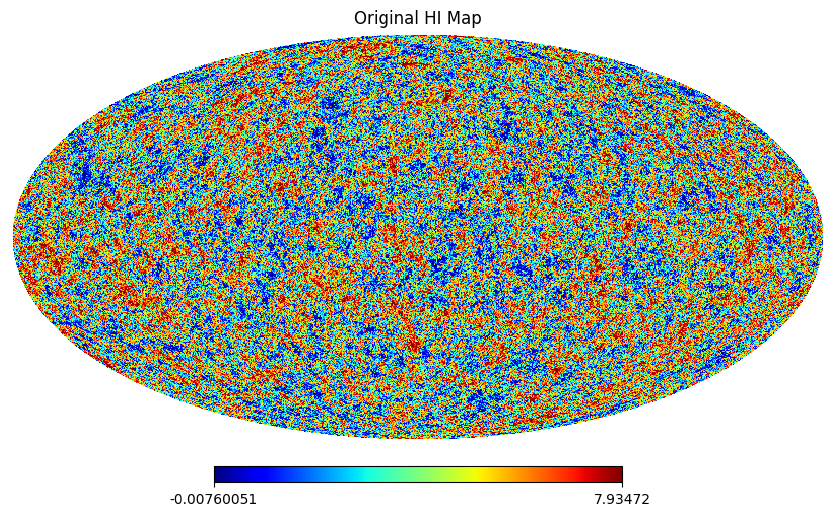

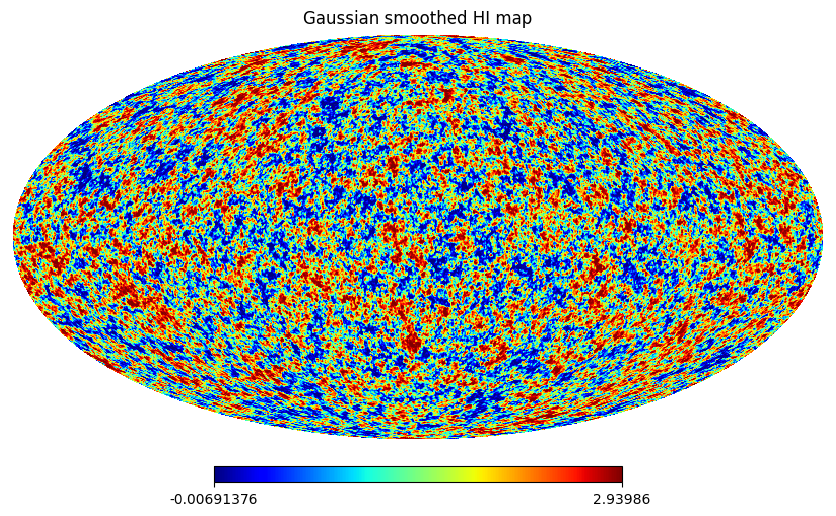

In [16]:
# Visualize results
g_smoothed_map = hp.smoothing(HI[0], beam_window=blg)
hp.mollview(HI[0], cmap='jet', norm='hist', title='Original HI Map')
hp.mollview(g_smoothed_map, cmap='jet', norm='hist', title='Gaussian smoothed HI map')

## Selecting range

The idea here is to select a group of pixels in our original map and apply it to its distribution in the convolved map counterpart.

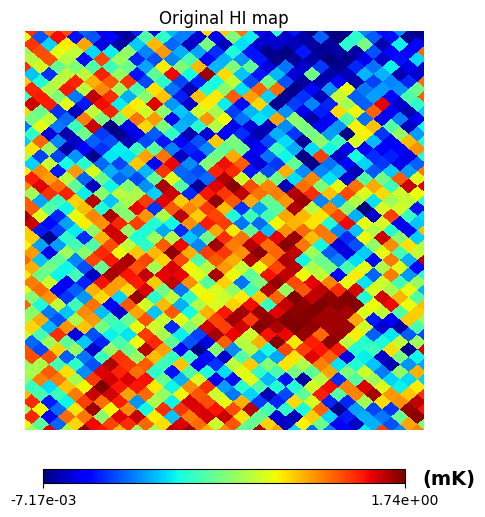

In [17]:
# Original Cartview
og_dec = [-4, 4]
og_ra = [-4, 4]
hp.cartview(HI[0], 
            norm="hist", 
            latra=[og_dec[0],og_dec[1]], 
            lonra=[og_ra[0],og_ra[1]], 
            cmap='jet', format='%.2e', unit=r'(mK)', title='Original HI map')

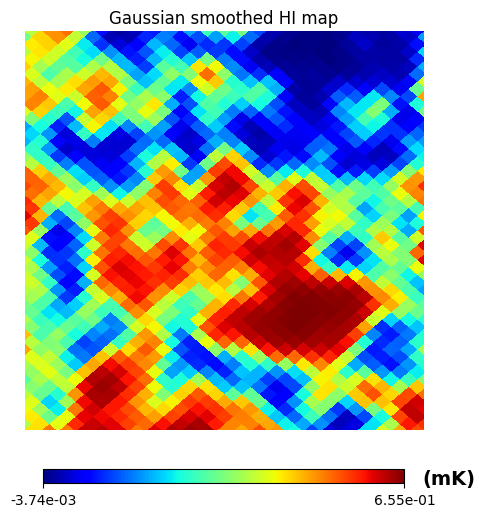

In [18]:
# Gaussian smoothed Cartview
smoothed_dec = [-4, 4]
smoothed_ra = [-4, 4]
hp.cartview(g_smoothed_map, 
            norm="hist", 
            latra=[smoothed_dec[0],smoothed_dec[1]], 
            lonra=[smoothed_ra[0],smoothed_ra[1]], 
            cmap='jet', format='%.2e', unit=r'(mK)', title='Gaussian smoothed HI map')

## Converting coordinates to pixel values

We need now to create an algorithm that finds our defined coordinates and get the pixel values of the selected range.

In [19]:
# Original map values
og_map = HI[0]

# Convert RA and Dec to theta (colatitude) and phi (longitude) in radians
og_theta = np.zeros(2)
og_theta[0] = np.radians(90.0 - og_dec[1]) # theta_min
og_theta[1] = np.radians(90.0 - og_dec[0]) # theta_max

og_phi = np.zeros(2)
og_phi[0] = np.radians(og_ra[0]) # phi_min
og_phi[1] = np.radians(og_ra[1]) # phi_max

# Define the number of points for a finer grid
n_points = 100

# Create a grid of theta and phi values within the specified range
og_theta_vals = np.linspace(og_theta[0], og_theta[1], n_points)
og_phi_vals = np.linspace(og_phi[0], og_phi[1], n_points)
og_theta_grid, og_phi_grid = np.meshgrid(og_theta_vals, og_phi_vals)

# Convert theta and phi grid to HEALPix pixel indices
og_nside = hp.npix2nside(len(og_map))
og_pix_indices = hp.ang2pix(og_nside, og_theta_grid.flatten(), og_phi_grid.flatten())

# Extract the unique pixel indices and corresponding pixel values
og_unique_pix_indices = np.unique(og_pix_indices)
og_region_values = og_map[og_unique_pix_indices]

# Create a new map with the same resolution as the original map
og_new_map = np.full(len(og_map), hp.UNSEEN)

# Set the pixel values in the selected region
og_new_map[og_unique_pix_indices] = og_region_values

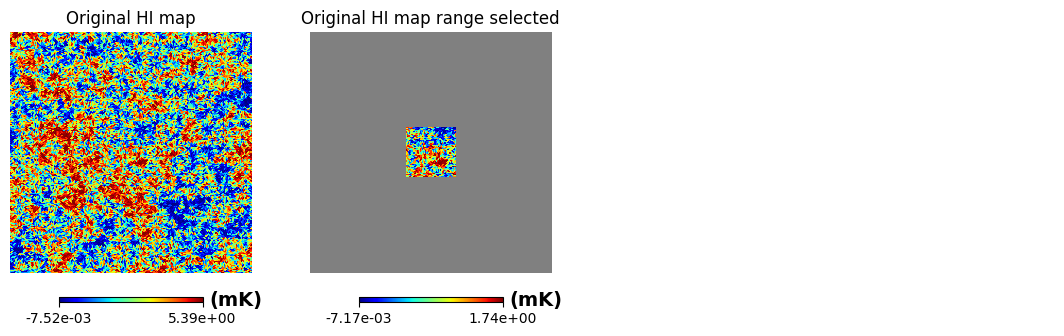

In [23]:
# Visualize and compare
og_dec = [-20, 20]
og_ra = [-20, 20]

fig, axes = plt.subplots(1, 2, figsize=(12, 3),
                         subplot_kw={'projection': None},
                         gridspec_kw={'wspace': 0.1})

og_titles = [
    'Original HI map',
    'Original HI map range selected'
]

og_maps = [og_map, og_new_map]

# Plot each map individually
hp.cartview(og_maps[0], norm="hist", latra=[og_dec[0],og_dec[1]], lonra=[og_ra[0],og_ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=og_titles[0], fig=fig, sub=(1, 4, 1))
hp.cartview(og_maps[1], norm="hist", latra=[og_dec[0],og_dec[1]], lonra=[og_ra[0],og_ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=og_titles[1], fig=fig, sub=(1, 4, 2))

# Hide the axes for all subplots to remove traces
for ax in axes:
    ax.set_axis_off()

#plt.savefig('cartview_maps.png', bbox_inches='tight')

plt.show()

In [24]:
# Gaussian smoothed map values

# Convert RA and Dec to theta (colatitude) and phi (longitude) in radians
smoothed_theta = np.zeros(2)
smoothed_theta[0] = np.radians(90.0 - smoothed_dec[1]) # theta_min
smoothed_theta[1] = np.radians(90.0 - smoothed_dec[0]) # theta_max

smoothed_phi = np.zeros(2)
smoothed_phi[0] = np.radians(smoothed_ra[0]) # phi_min
smoothed_phi[1] = np.radians(smoothed_ra[1]) # phi_max

# Define the number of points for a finer grid
n_points = 100

# Create a grid of theta and phi values within the specified range
smoothed_theta_vals = np.linspace(smoothed_theta[0], smoothed_theta[1], n_points)
smoothed_phi_vals = np.linspace(smoothed_phi[0], smoothed_phi[1], n_points)
smoothed_theta_grid, smoothed_phi_grid = np.meshgrid(smoothed_theta_vals, smoothed_phi_vals)

# Convert theta and phi grid to HEALPix pixel indices
smoothed_nside = hp.npix2nside(len(g_smoothed_map))
smoothed_pix_indices = hp.ang2pix(smoothed_nside, smoothed_theta_grid.flatten(), smoothed_phi_grid.flatten())

# Extract the unique pixel indices and corresponding pixel values
smoothed_unique_pix_indices = np.unique(smoothed_pix_indices)
smoothed_region_values = g_smoothed_map[smoothed_unique_pix_indices]

# Create a new map with the same resolution as the original map
smoothed_new_map = np.full(len(g_smoothed_map), hp.UNSEEN)

# Set the pixel values in the selected region
smoothed_new_map[smoothed_unique_pix_indices] = smoothed_region_values

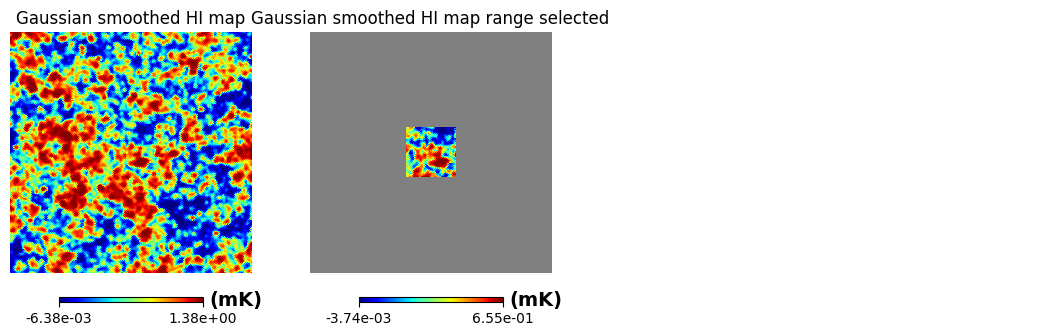

In [25]:
# Visualize and compare
smoothed_dec = [-20, 20]
smoothed_ra = [-20, 20]

fig, axes = plt.subplots(1, 2, figsize=(12, 3),
                         subplot_kw={'projection': None},
                         gridspec_kw={'wspace': 0.1})

smoothed_titles = [
    'Gaussian smoothed HI map',
    'Gaussian smoothed HI map range selected'
]

smoothed_maps = [g_smoothed_map, smoothed_new_map]

# Plot each map individually
hp.cartview(smoothed_maps[0], norm="hist", latra=[smoothed_dec[0],smoothed_dec[1]], lonra=[smoothed_ra[0],smoothed_ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=smoothed_titles[0], fig=fig, sub=(1, 4, 1))
hp.cartview(smoothed_maps[1], norm="hist", latra=[smoothed_dec[0],smoothed_dec[1]], lonra=[smoothed_ra[0],smoothed_ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=smoothed_titles[1], fig=fig, sub=(1, 4, 2))

# Hide the axes for all subplots to remove traces
for ax in axes:
    ax.set_axis_off()

#plt.savefig('cartview_maps.png', bbox_inches='tight')

plt.show()

## Generalize and apply to the different 30 bands

Let's first make our lives easy and define 2 functions: one to smooth the map with the selected beam type and the other one to extract our pixels.

In [26]:
def smooth_map(healpix_map, nbands=30, nu_min=980, nu_max=1260, D=40, in_degree=True, type_='gaussian'):
    """
    Process a HEALPix map by adjusting frequency bands, calculating beam window function,
    and smoothing the map.
    The values of this function are adjusted for the BINGO radio-telescope.

    Parameters:
    - healpix_map: array-like
        The HEALPix map data.
    - nbands: int
        Number of frequency bands.
    - nu_min: float
        Minimum frequency of observation.
    - nu_max: float
        Maximum frequency of observation.
    - D: float
        Diameter for the dish.
    - in_degree: bool
        Whether to use degrees in the beam window function.
    - type_: str
        The type of the beam window function.

    Returns:
    - g_smoothed_map: array-like
        The smoothed HEALPix map.
    """
    # Adjusting nu
    nu_step = (nu_max - nu_min) / nbands
    nu = np.around(np.arange(nu_min, nu_max, nu_step), decimals=2)

    # Adjusting ell
    nside = hp.get_nside(healpix_map)
    lmax = 3 * nside
    l = np.arange(lmax + 1)

    # FWHM (Delta theta_r)
    fwhm = model.fwhm_modelling(nu=nu[0], type_='smooth', D=D, in_degree=in_degree)

    # Adjusting theta
    theta = np.arange(0, 10, 0.01)

    # Get beam window function
    bl = model.bl_function(type_=type_, fwhm=fwhm, lmax=lmax, theta_=theta, input_unit='degree')

    # Visualize results
    smoothed_map = hp.smoothing(healpix_map, beam_window=bl)

    return smoothed_map

In [27]:
def extract_pixels(healpix_map, dec_range, ra_range, n_points=100):
    """
    From declination and right ascension coordinates, 
    this function transforms them into pixel values from the original maps and returns the selected region in the form of a new HEALPix map.
    
    Parameters:
    - healpix_map: array-like
        The HEALPix map data.
    - dec_range: array-like
        Range of declination in degrees where dec_range[0] is the minimum and dec_range[1] is the maximum.
    - ra_range: array-like
        Range of right ascension in degrees where ra_range[0] is the minimum and ra_range[1] is the maximum.
    - n_points: int, optional
        Number of points for creating a finer grid. Default is 100.
        
    Returns:
    - new_healpix_map: array-like
        New HEALPix map data with selected range.
    """
    # Convert RA and Dec to theta (colatitude) and phi (longitude) in radians
    theta = np.zeros(2)
    theta[0] = np.radians(90.0 - dec_range[1]) # theta_min
    theta[1] = np.radians(90.0 - dec_range[0]) # theta_max
    
    phi = np.zeros(2)
    phi[0] = np.radians(ra_range[0]) # phi_min
    phi[1] = np.radians(ra_range[1]) # phi_max
    
    # Define the number of points for a finer grid
    n_points = 100
    
    # Create a grid of theta and phi values within the specified range
    theta_vals = np.linspace(theta[0], theta[1], n_points)
    phi_vals = np.linspace(phi[0], phi[1], n_points)
    theta_grid, phi_grid = np.meshgrid(theta_vals, phi_vals)
    
    # Convert theta and phi grid to HEALPix pixel indices
    nside = hp.npix2nside(len(healpix_map))
    pix_indices = hp.ang2pix(nside, theta_grid.flatten(), phi_grid.flatten())
    
    # Extract the unique pixel indices and corresponding pixel values
    unique_pix_indices = np.unique(pix_indices)
    region_values = healpix_map[unique_pix_indices]
    
    # Create a new map with the same resolution as the original map
    new_healpix_map = np.full(len(healpix_map), hp.UNSEEN)
    
    # Set the pixel values in the selected region
    new_healpix_map[unique_pix_indices] = region_values

    return new_healpix_map

In [32]:
# Extract pixels and save them

og_dec = [-4, 4]
og_ra = [-4, 4]
smoothed_dec = [-4, 4]
smoothed_ra = [-4, 4]

for i in range(len(HI)):
    # Original maps
    og_map = HI[i]
    new_og_map = extract_pixels(og_map, dec_range=og_dec, ra_range=og_ra)

    # Gaussian beam maps
    g_smoothed_map = smooth_map(og_map, type_='gaussian')
    new_g_smoothed_map = extract_pixels(g_smoothed_map, dec_range=smoothed_dec, ra_range=smoothed_ra)

    # Cosine beam maps
    c_smoothed_map = smooth_map(og_map, type_='cosine')
    new_c_smoothed_map = extract_pixels(c_smoothed_map, dec_range=smoothed_dec, ra_range=smoothed_ra)

    # Jinc beam maps
    j_smoothed_map = smooth_map(og_map, type_='jinc')
    new_j_smoothed_map = extract_pixels(j_smoothed_map, dec_range=smoothed_dec, ra_range=smoothed_ra)

    # Save as HEALPix FITS files
    hp.write_map(f'/media/BINGODATA1/BeamAnalysis/preliminary_dataset/og_maps/og_map_{i+1}.fits', new_og_map, overwrite=True)
    hp.write_map(f'/media/BINGODATA1/BeamAnalysis/preliminary_dataset/gaussian_smoothed_maps/g_smoothed_map_{i+1}.fits', new_g_smoothed_map, overwrite=True)
    hp.write_map(f'/media/BINGODATA1/BeamAnalysis/preliminary_dataset/cosine_smoothed_maps/c_smoothed_map_{i+1}.fits', new_c_smoothed_map, overwrite=True)
    hp.write_map(f'/media/BINGODATA1/BeamAnalysis/preliminary_dataset/jinc_smoothed_maps/j_smoothed_map_{i+1}.fits', new_j_smoothed_map, overwrite=True)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to

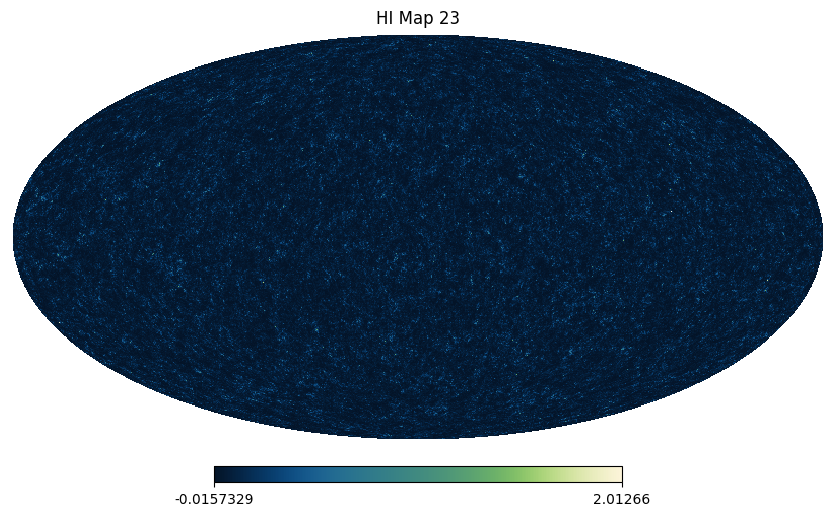

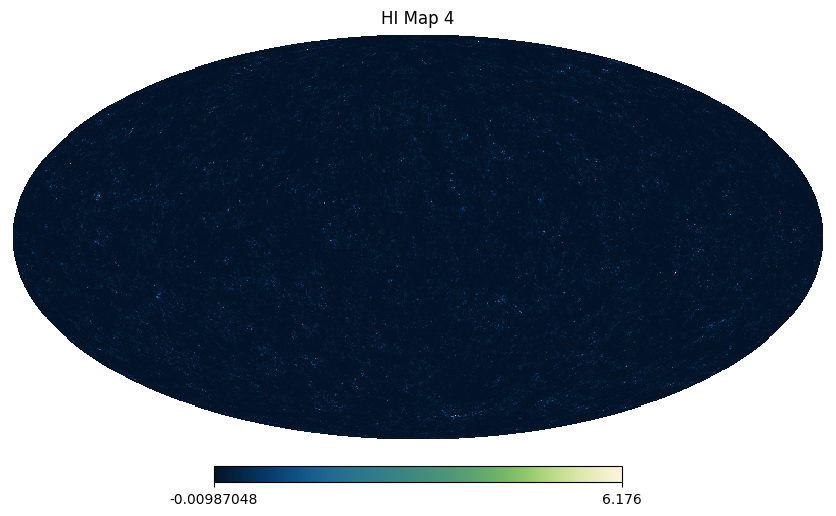

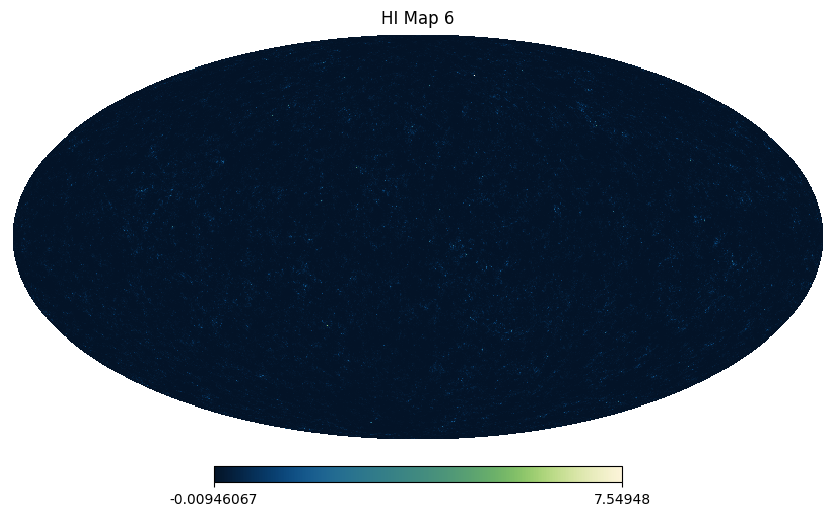

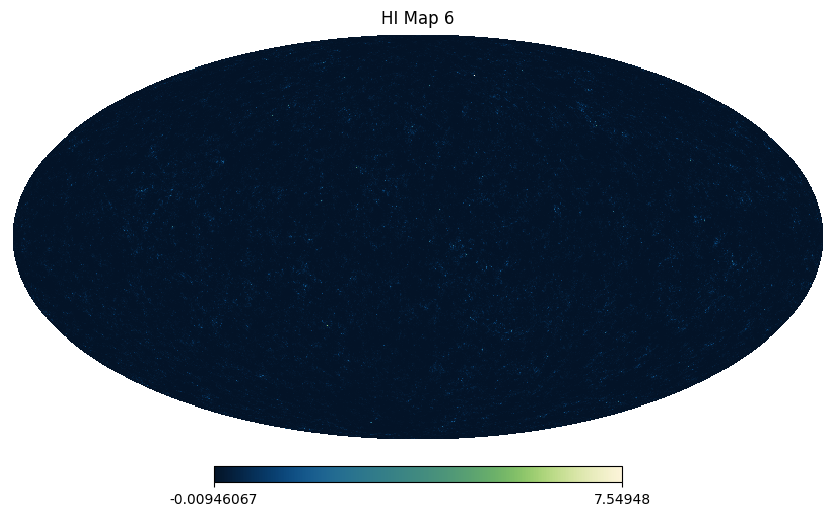

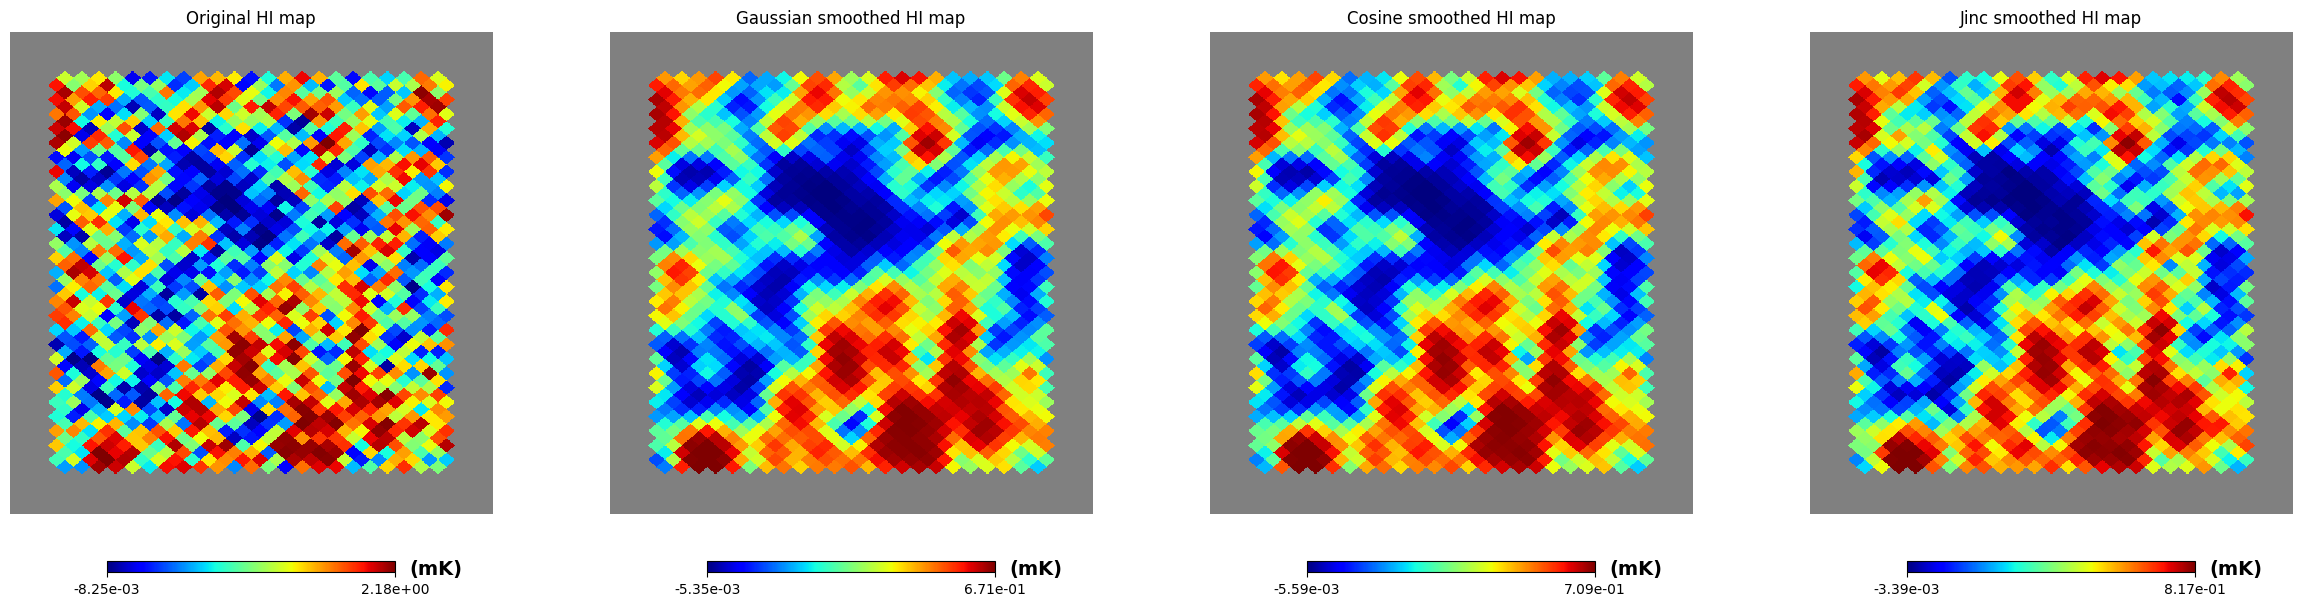

In [39]:
# Open maps
number = np.random.randint(1,30)

og_dec = [-5, 5]
og_ra = [-5, 5]
smoothed_dec = [-5, 5]
smoothed_ra = [-5, 5]

path = "/media/BINGODATA1/BeamAnalysis/preliminary_dataset/"
og_filename = f'og_maps/og_map_{number}.fits'
g_filename = f'gaussian_smoothed_maps/g_smoothed_map_{number}.fits'
c_filename = f'cosine_smoothed_maps/c_smoothed_map_{number}.fits'
j_filename = f'jinc_smoothed_maps/j_smoothed_map_{number}.fits'

og_map = hdata.getmap(dirpath_=path, filename_=og_filename, healpix_readingformat=True, hdu=1)
g_map = hdata.getmap(dirpath_=path, filename_=g_filename, healpix_readingformat=True, hdu=1)
c_map = hdata.getmap(dirpath_=path, filename_=c_filename, healpix_readingformat=True, hdu=1)
j_map = hdata.getmap(dirpath_=path, filename_=j_filename, healpix_readingformat=True, hdu=1)

# Plot and compare
fig, axes = plt.subplots(1, 4, figsize=(24, 6),
                         subplot_kw={'projection': None},
                         gridspec_kw={'wspace': 0.1})

smoothed_titles = [
    'Original HI map',
    'Gaussian smoothed HI map',
    'Cosine smoothed HI map',
    'Jinc smoothed HI map'
]

maps = [og_map, g_map, c_map, j_map]

# Plot each map individually
hp.cartview(maps[0], norm="hist", latra=[og_dec[0],og_dec[1]], lonra=[og_ra[0],og_ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=smoothed_titles[0], fig=fig, sub=(1, 4, 1))
hp.cartview(maps[1], norm="hist", latra=[smoothed_dec[0],smoothed_dec[1]], lonra=[smoothed_ra[0],smoothed_ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=smoothed_titles[1], fig=fig, sub=(1, 4, 2))
hp.cartview(maps[2], norm="hist", latra=[smoothed_dec[0],smoothed_dec[1]], lonra=[smoothed_ra[0],smoothed_ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=smoothed_titles[2], fig=fig, sub=(1, 4, 3))
hp.cartview(maps[3], norm="hist", latra=[smoothed_dec[0],smoothed_dec[1]], lonra=[smoothed_ra[0],smoothed_ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=smoothed_titles[3], fig=fig, sub=(1, 4, 4))

# Hide the axes for all subplots to remove traces
for ax in axes:
    ax.set_axis_off()

#plt.savefig('limited_cartview_maps.png', bbox_inches='tight')

plt.show()